In [302]:
import lime
from lime import lime_image
from skimage.color import label2rgb
from skimage.segmentation import mark_boundaries
import contextlib

import pandas as pd
from pathlib import Path
import os
import csv
import glob
import shutil
from collections import Counter
import numpy as np
import tensorflow as tf
import keras
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import sklearn
from random import shuffle
from keras.layers import *
from keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from itertools import chain
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from scipy.ndimage import shift, map_coordinates, gaussian_filter
from sklearn.model_selection import StratifiedKFold 
from sklearn.utils.class_weight import compute_class_weight

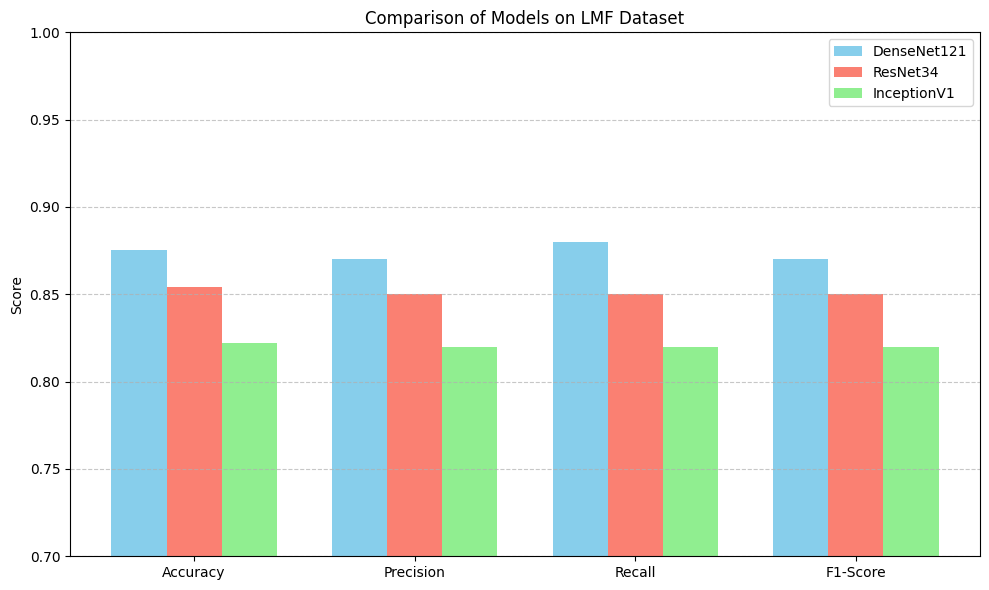

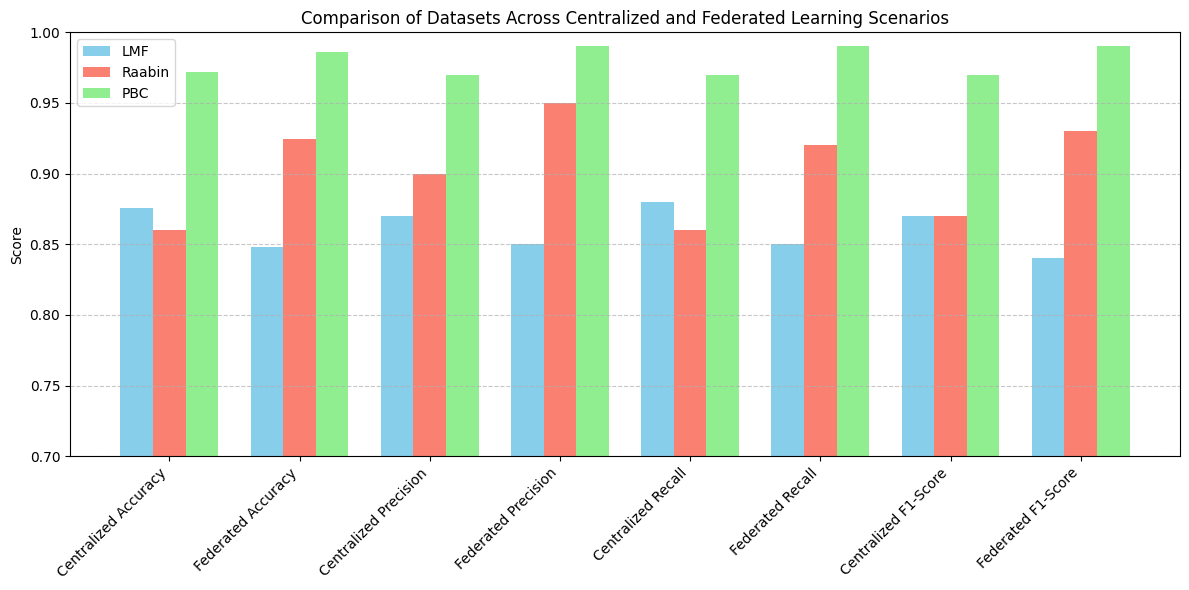

In [310]:
# Figure 1: Adjusted y-axis range with break (0.5-1.0) for model comparison on LMF
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
densenet121 = [0.8754, 0.87, 0.88, 0.87]
resnet34 = [0.8544, 0.85, 0.85, 0.85]
inceptionv1 = [0.8221, 0.82, 0.82, 0.82]

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, densenet121, width, label='DenseNet121', color='skyblue')
plt.bar(x, resnet34, width, label='ResNet34', color='salmon')
plt.bar(x + width, inceptionv1, width, label='InceptionV1', color='lightgreen')

plt.xticks(x, metrics)
plt.ylabel('Score')
plt.ylim(0.7, 1.0)  # Set y-axis range from 0.5 to 1.0
plt.title('Comparison of Models on LMF Dataset')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('/mnt/c/Users/Dhruba/images for WBC/results/centralized_vs_federated_comparison.png')
plt.show()

# Figure 2: Adjusted y-axis range with break (0.5-1.0) for dataset comparison in FL
metrics = ['Centralized Accuracy', 'Federated Accuracy', 'Centralized Precision', 'Federated Precision', 'Centralized Recall', 'Federated Recall',
           'Centralized F1-Score', 'Federated F1-Score']
lmf = [0.8754, 0.8479, 0.87, 0.85, 0.88, 0.85, 0.87, 0.84]
raabin = [0.8602, 0.9242, 0.90, 0.95, 0.86, 0.92, 0.87, 0.93]
pbc = [0.9719, 0.9858, 0.97, 0.99, 0.97, 0.99, 0.97, 0.99]

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, lmf, width, label='LMF', color='skyblue')
plt.bar(x, raabin, width, label='Raabin', color='salmon')
plt.bar(x + width, pbc, width, label='PBC', color='lightgreen')

plt.xticks(x, metrics, rotation=45, ha='right')
plt.ylabel('Score')
plt.ylim(0.7, 1.0)  # Set y-axis range from 0.5 to 1.0
plt.title('Comparison of Datasets Across Centralized and Federated Learning Scenarios')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

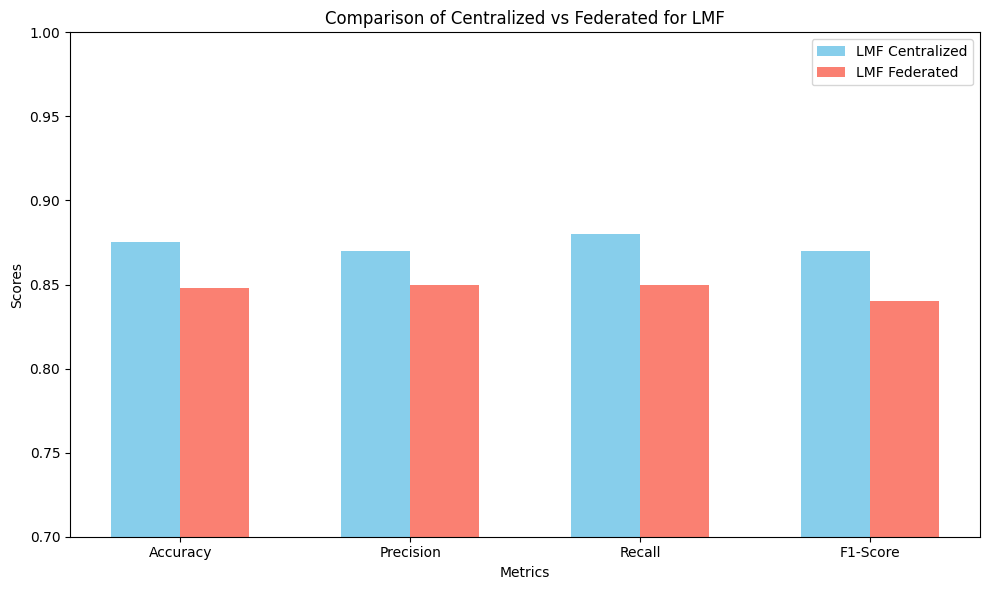

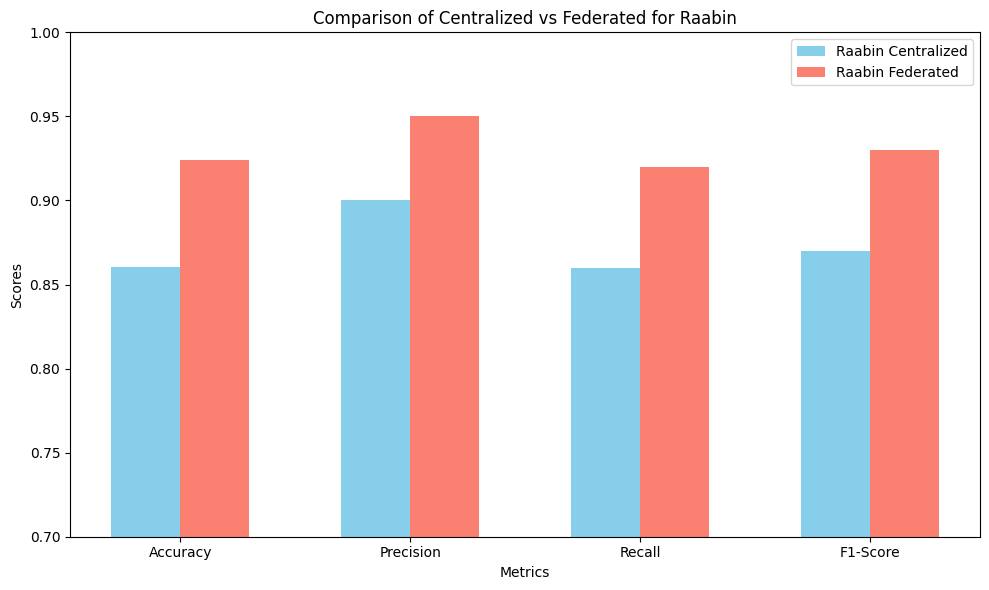

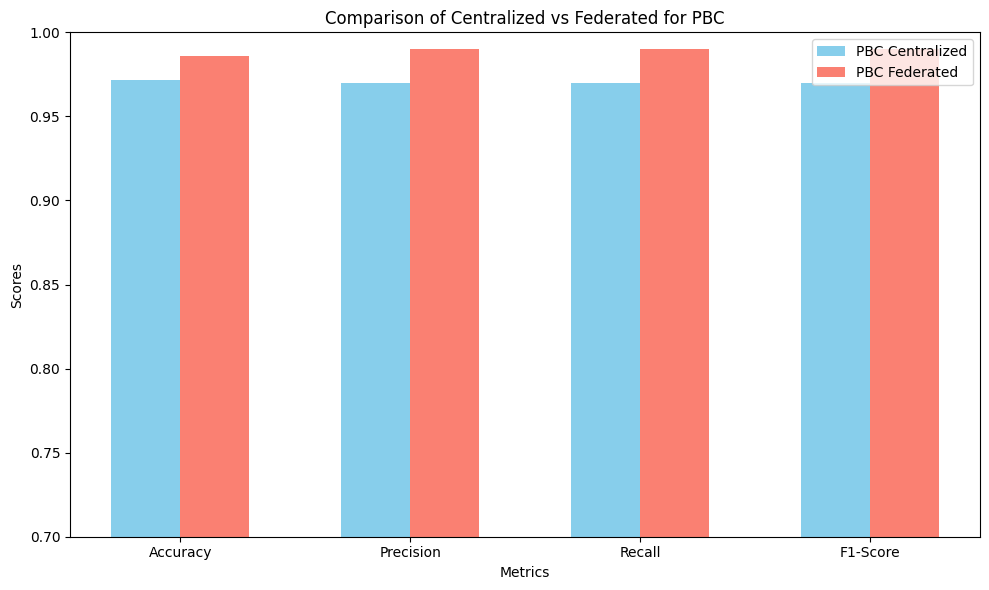

In [317]:

# Metrics for Centralized and Federated settings for each dataset
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Data: Centralized vs Federated performance for each dataset
lmf_centralized = [0.8754, 0.87, 0.88, 0.87]   # Centralized values for LMF
lmf_federated = [0.8479, 0.85, 0.85, 0.84]     # Federated values for LMF

raabin_centralized = [0.8602, 0.90, 0.86, 0.87] # Centralized values for Raabin
raabin_federated = [0.9242, 0.95, 0.92, 0.93]   # Federated values for Raabin

pbc_centralized = [0.9719, 0.97, 0.97, 0.97]    # Centralized values for PBC
pbc_federated = [0.9858, 0.99, 0.99, 0.99]      # Federated values for PBC

# Positioning for bars
x = np.arange(len(metrics))
width = 0.3  # Width of the bars

# Create individual figures for each dataset
datasets = ['LMF', 'Raabin', 'PBC']
centralized_data = [lmf_centralized, raabin_centralized, pbc_centralized]
federated_data = [lmf_federated, raabin_federated, pbc_federated]

# Create subplots for each dataset
for i, dataset in enumerate(datasets):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - width/2, centralized_data[i], width, label=f'{dataset} Centralized', color='skyblue')
    ax.bar(x + width/2, federated_data[i], width, label=f'{dataset} Federated', color='salmon')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(f'Comparison of Centralized vs Federated for {dataset}')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.set_ylim(0.7, 1.0) 
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'/mnt/c/Users/Dhruba/images for WBC/results/centralized_vs_federated_comparison_{i+1}.png')
    plt.show()

In [84]:
def split_dataset(x_test, y_test_encoded, num_splits):
    """
    Splits a dataset into smaller datasets such that all classes are present in each split.
    Returns:
        list: A list of tuples, where each tuple contains a smaller dataset (x_split, y_split).
    """   
    # StratifiedKFold will split maintaining class distribution
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    y_test = np.argmax(y_test_encoded, axis=1)
    
    splits = []
    for _, split_indices in tqdm(skf.split(x_test, y_test)):
        x_split = x_test[split_indices]
        y_split = y_test[split_indices]
        splits.append((x_split, y_split))
    
    return splits

# Split into 20 parts
splits = split_dataset(x_test_lmf, y_test_encoded_lmf, num_splits=10)

# Example: Check the size and classes in each split
for i, (x_split, y_split) in enumerate(splits):
    print(f"Split {i+1}: {len(x_split)} samples, Classes: {np.unique(y_split)}")

# x_val = splits[10][0]
# y_val = splits[10][1]
# y_val = to_categorical(y_val)

10it [00:01,  5.95it/s]

Split 1: 2549 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 2: 2549 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 3: 2549 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 4: 2549 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 5: 2549 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 6: 2549 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 7: 2549 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 8: 2549 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 9: 2549 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 10: 2549 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [296]:
best_model = load_model('/mnt/c/Users/Dhruba/Codes/saved models/WBC_fd1_dns.v_acc_0.838-loss_2.527.keras', compile = True)

In [297]:
accuracy_list = []
CM = []
mac_auc = []
mic_auc = [] 
Y = []
Pred = []
for i in tqdm(range(10)):  
    x = splits[i][0]
    y = splits[i][1]
    
    # y_encoded = to_categorical(y)
    # best_model.evaluate(x, y_encoded, batch_size=40, verbose=1)
    
    y_pred = best_model.predict(x, batch_size=40,  verbose=0)
    
    ##sparse_gt = np.argmax(y, axis=0) ##y is already sparse here
    sparse_pred = np.argmax(y_pred, axis=1)
    
    ### Calculate accuracy
    accuracy = accuracy_score(y, sparse_pred)
    print("Accuracy:", accuracy)
    accuracy_list.append(accuracy)

    cm = confusion_matrix(y, sparse_pred)
    CM.append(cm)

    # Calculate macro-averaged AUC
    macro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="macro") 
    mac_auc.append(macro_auc)
    # Calculate micro-averaged AUC
    micro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="micro") 
    mic_auc.append(micro_auc)

    # # Calculate precision, recall, and F1-score for each class
    # precision = precision_score(y, sparse_pred, average=None)
    # recall = recall_score(y, sparse_pred, average=None)
    # f1 = f1_score(y, sparse_pred, average=None)
    
    # # Calculate macro, micro, and weighted scores
    # macro_f1 = f1_score(y, sparse_pred, average='macro')
    # micro_f1 = f1_score(y, sparse_pred, average='micro')
    # weighted_f1 = f1_score(y, sparse_pred, average='weighted')
    
    Y.append(y)
    Pred.append(sparse_pred)

 10%|████████▍                                                                           | 1/10 [00:15<02:17, 15.28s/it]

Accuracy: 0.8430757159670459


 20%|████████████████▊                                                                   | 2/10 [00:17<01:01,  7.69s/it]

Accuracy: 0.8630835621812476


 30%|█████████████████████████▏                                                          | 3/10 [00:19<00:36,  5.16s/it]

Accuracy: 0.8501373087485289


 40%|█████████████████████████████████▌                                                  | 4/10 [00:21<00:23,  3.99s/it]

Accuracy: 0.841114162416634


 50%|██████████████████████████████████████████                                          | 5/10 [00:24<00:16,  3.36s/it]

Accuracy: 0.8536681051392703


 60%|██████████████████████████████████████████████████▍                                 | 6/10 [00:26<00:11,  2.90s/it]

Accuracy: 0.8520988622989407


 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [00:28<00:07,  2.62s/it]

Accuracy: 0.8513142408787759


 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [00:30<00:04,  2.44s/it]

Accuracy: 0.8422910945468811


 90%|███████████████████████████████████████████████████████████████████████████▌        | 9/10 [00:32<00:02,  2.23s/it]

Accuracy: 0.8450372695174578


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.44s/it]

Accuracy: 0.8375833660258926


In [298]:
total_acc = sum(accuracy_list[:10])/10
print("Accuracy of model on full test data: ", total_acc)

macro_auc = sum(mac_auc[:10])/10
print("Macro-averaged AUC on full test data: ", macro_auc)

micro_auc = sum(mic_auc[:10])/10
print("Micro-averaged AUC on full test data: ", micro_auc)

Accuracy of model on full test data:  0.8479403687720675
Macro-averaged AUC on full test data:  0.9803747444987831
Micro-averaged AUC on full test data:  0.9897457496210151


In [299]:
y_true = list(chain.from_iterable(Y))
y_gt = list(chain.from_iterable(Pred))

In [300]:
# Print classification report
report = classification_report(y_true, y_gt, target_names=[f"Class {i}" for i in range(16)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.94      0.84      0.89      1050
     Class 1       1.00      0.96      0.98       410
     Class 2       0.66      0.45      0.53      1110
     Class 3       0.99      0.80      0.89       130
     Class 4       0.54      0.57      0.55      1870
     Class 5       0.93      0.93      0.93      1000
     Class 6       0.66      1.00      0.80        80
     Class 7       0.75      0.71      0.73      3520
     Class 8       0.96      0.94      0.95      4210
     Class 9       0.48      0.44      0.46       510
    Class 10       0.76      0.92      0.83       990
    Class 11       0.78      0.80      0.79      1090
    Class 12       0.82      0.87      0.84       150
    Class 13       0.67      0.07      0.12        30
    Class 14       0.92      0.98      0.95      8550
    Class 15       0.95      0.87      0.91       790

    accuracy                           0.85     25490
  

In [294]:
# Read the CSV file
df = pd.read_csv("/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/labels.csv")
# Find unique values in the 'column_name' column
unique_values = df['label'].unique()
# Define the strings to remove
to_remove = ['artifact', 'unk_wbc']
# Find the indices of the strings to be removed
indices = [i for i, val in enumerate(unique_values) if val in to_remove]
# Delete the elements at the found indices
updated_class = np.delete(unique_values, indices)

print(len(updated_class))
sorted_class = np.sort(updated_class)
print(sorted_class)

16
['abnormal_lymphocyte' 'agg_plt' 'band_neutrophil' 'basophil' 'blast'
 'eosinophil' 'g_plt' 'immature_wbc' 'lymphocyte' 'metamyelocyte'
 'monocyte' 'myelocyte' 'n_rbc' 'promyelocyte' 'seg_neutrophil' 'smudge']


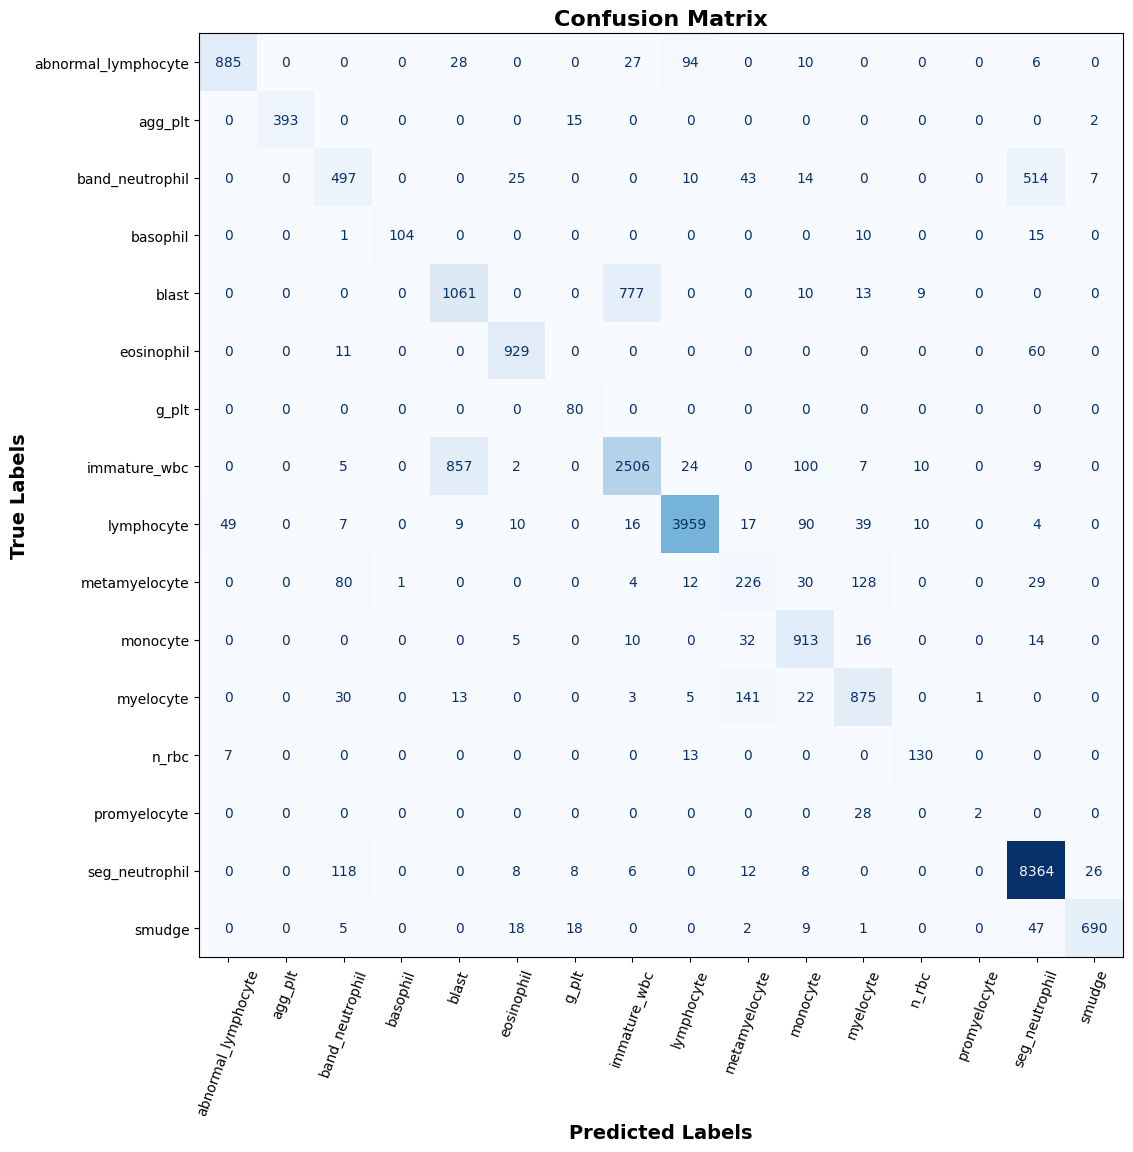

In [301]:
final_cm = sum(CM[:20])  # Sums up elements cm[0] to cm[19]

# Create display labels
class_names = sorted_class
plt.figure(figsize=(12, 12))
# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)

## Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
## Rotate x-axis labels
plt.xticks(rotation=70)

# Customize the title and axis labels
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=14, fontweight='bold')
plt.ylabel("True Labels", fontsize=14, fontweight='bold')

#plt.tight_layout()
output_filename = "/mnt/c/Users/Dhruba/images for WBC/Confusion matrix/LMF_fed.tiff"
plt.savefig(output_filename, dpi=300, format='tiff', bbox_inches='tight')
# plt.savefig('CM_centralized.png') 
plt.show()

In [140]:
best_model = load_model('/mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd5_wght_dns.v_acc_0.924-loss_1.129.keras', compile = True)

In [141]:
y_pred = best_model.predict(x_test_raabin, batch_size=40,  verbose=0)

sparse_gt = np.argmax(y_test_encoded_raabin, axis=1)
sparse_pred = np.argmax(y_pred, axis=1)

### Calculate accuracy
accuracy = accuracy_score(sparse_gt, sparse_pred)
#print("Accuracy:", accuracy)

cm = confusion_matrix(sparse_gt, sparse_pred)
# Calculate macro-averaged AUC
macro_auc = roc_auc_score(sparse_gt, y_pred, multi_class="ovr", average="macro") 
# Calculate micro-averaged AUC
micro_auc = roc_auc_score(sparse_gt, y_pred, multi_class="ovr", average="micro") 

print("Accuracy of model on full test data: ", accuracy)
print("Macro-averaged AUC on full test data: ", macro_auc)
print("Micro-averaged AUC on full test data: ", micro_auc)

Accuracy of model on full test data:  0.9242799628367916
Macro-averaged AUC on full test data:  0.9895484422851883
Micro-averaged AUC on full test data:  0.9911362341905545


In [142]:
# Print classification report
report = classification_report(sparse_gt, sparse_pred, target_names=[f"Class {i}" for i in range(5)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.41      1.00      0.58        89
     Class 1       0.84      0.87      0.85       322
     Class 2       0.99      0.87      0.92      1182
     Class 3       0.52      0.95      0.67       234
     Class 4       0.98      0.94      0.96      4631

    accuracy                           0.92      6458
   macro avg       0.75      0.92      0.80      6458
weighted avg       0.95      0.92      0.93      6458



In [305]:
best_model = load_model('/mnt/c/Users/Dhruba/Codes/saved models/PBC_wght_dns.ep04-test_acc_0.972.keras', compile = True)

In [306]:
y_pred = best_model.predict(x_test_pbc, batch_size=40,  verbose=0)

sparse_gt = np.argmax(y_test_encoded_pbc, axis=1)
sparse_pred = np.argmax(y_pred, axis=1)

### Calculate accuracy
accuracy = accuracy_score(sparse_gt, sparse_pred)
#print("Accuracy:", accuracy)

cm = confusion_matrix(sparse_gt, sparse_pred)
# Calculate macro-averaged AUC
macro_auc = roc_auc_score(sparse_gt, y_pred, multi_class="ovr", average="macro") 
# Calculate micro-averaged AUC
micro_auc = roc_auc_score(sparse_gt, y_pred, multi_class="ovr", average="micro") 

print("Accuracy of model on full test data: ", accuracy)
print("Macro-averaged AUC on full test data: ", macro_auc)
print("Micro-averaged AUC on full test data: ", micro_auc)

Accuracy of model on full test data:  0.9719407638347622
Macro-averaged AUC on full test data:  0.9992466463383394
Micro-averaged AUC on full test data:  0.999139724956722


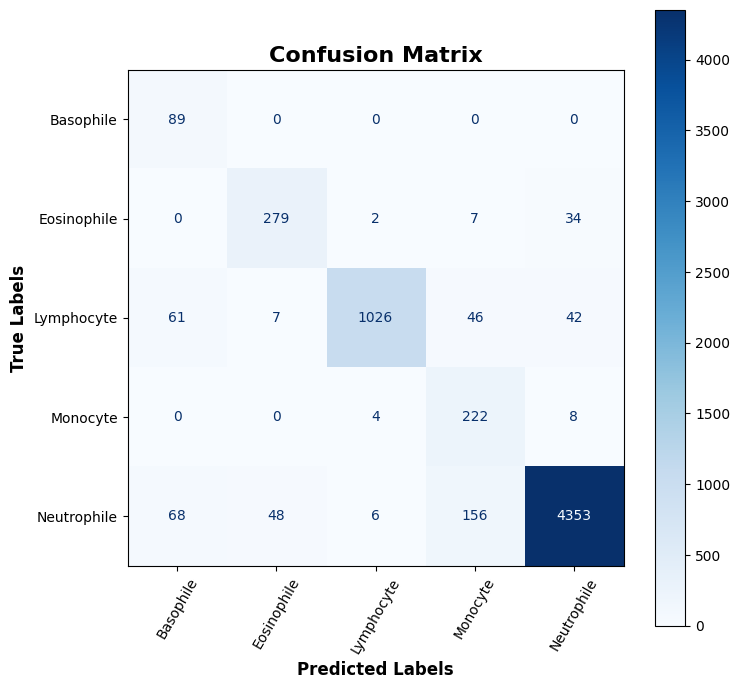

In [282]:
class_names = ['Basophile', 'Eosinophile', 'Lymphocyte', 'Monocyte', 'Neutrophile']
plt.figure(figsize=(8, 8))
# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

## Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=True)
## Rotate x-axis labels
plt.xticks(rotation=60)

# Customize the title and axis labels
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=12, fontweight='bold')
plt.ylabel("True Labels", fontsize=12, fontweight='bold')

output_filename = "/mnt/c/Users/Dhruba/images for WBC/Confusion matrix/Raabin_fed.tiff"
plt.savefig(output_filename, dpi=300, format='tiff', bbox_inches='tight')
#plt.tight_layout()
plt.show()

In [307]:
# Print classification report
report = classification_report(sparse_gt, sparse_pred, target_names=[f"Class {i}" for i in range(8)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.93      0.99      0.96       366
     Class 1       1.00      1.00      1.00       936
     Class 2       1.00      0.93      0.96       466
     Class 3       0.95      0.93      0.94       869
     Class 4       0.96      0.99      0.98       365
     Class 5       0.98      0.92      0.95       426
     Class 6       0.97      0.99      0.98       999
     Class 7       0.99      1.00      0.99       705

    accuracy                           0.97      5132
   macro avg       0.97      0.97      0.97      5132
weighted avg       0.97      0.97      0.97      5132



In [78]:
x_test_lmf = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/test_data.npy')
y_test_encoded_lmf = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/test_label.npy')

x_test_raabin = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Test/test_data.npy')
y_test_encoded_raabin = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Test/test_label_enc.npy')

x_test_pbc = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset/test_data.npy')
y_test_encoded_pbc = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset/test_label_enc.npy')

In [263]:
best_model_c = load_model('/mnt/c/Users/Dhruba/Codes/saved models/PBC_fd8_wght_dns.v_acc_0.986-loss_0.113.keras', compile = True)
#best_model_f = load_model('/mnt/c/Users/Dhruba/Codes/saved models/Raabin_fd5_wght_dns.v_acc_0.924-loss_1.129.keras', compile = True)

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


/root/miniconda3/envs/tff/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['input_layer']]. Received: the structure of inputs=*
  warnings.warn(


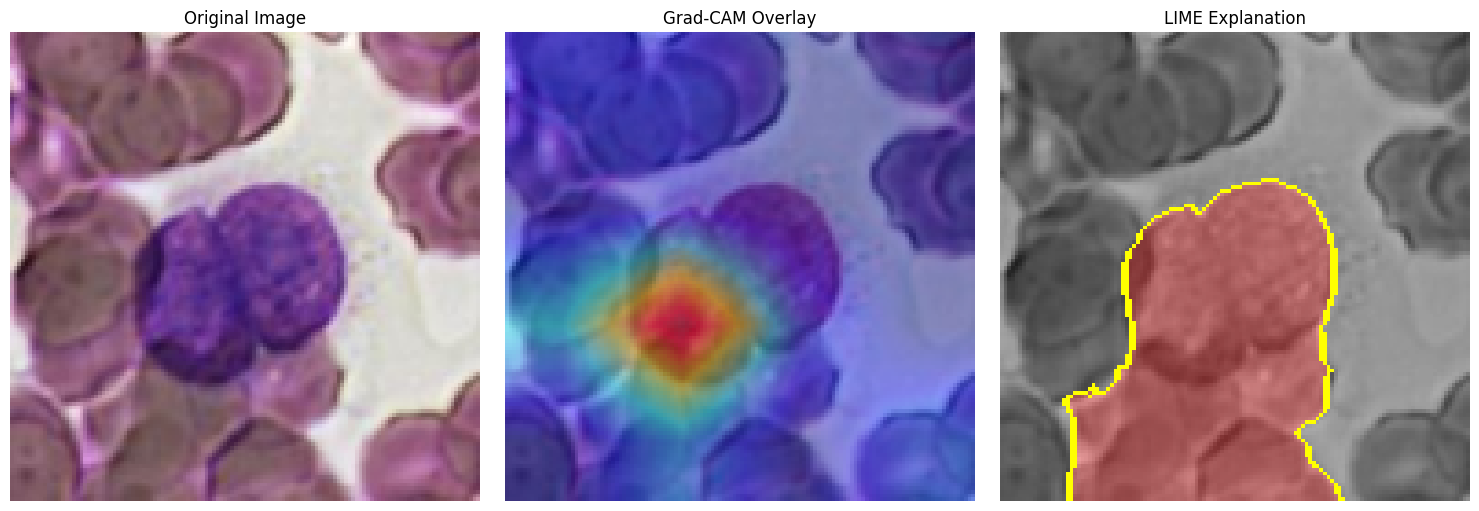

Plot saved as /mnt/c/Users/Dhruba/images for WBC/explainable AI images/LMF_f6.tiff in the local directory.


In [228]:
img_num = 6315

explainer = lime_image.LimeImageExplainer()

# Explain the prediction using LIME
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    explanation = explainer.explain_instance(x_test_lmf[img_num], best_model_c.predict, top_labels=5, hide_color=0, num_samples=500)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],  # Top predicted label
    positive_only=True,               # Show positive contributions only
    num_features=5,                   # Number of superpixels to highlight
    hide_rest=False                   # Show the rest of the image
)

# Overlay the mask on the original image
highlighted_image = label2rgb(mask, x_test_lmf[img_num], bg_label=0)


#for GradCam
image = np.expand_dims(x_test_lmf[img_num], axis=0)
heatmap = grad_cam(best_model_c, image, layer_name='conv2d_119')
# Overlay heatmap and display
overlayed_image = overlay_heatmap(heatmap, x_test_lmf[img_num]*255)

# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
# Plot each image
axes[0].imshow(x_test_lmf[img_num])
axes[0].axis('off')  # Hide axis
axes[0].set_title("Original Image")

axes[1].imshow(cv2.cvtColor(overlayed_image.astype('uint8'), cv2.COLOR_BGR2RGB))
axes[1].axis('off')
axes[1].set_title("Grad-CAM Overlay")

axes[2].imshow(mark_boundaries(highlighted_image, mask))
axes[2].axis('off')
axes[2].set_title("LIME Explanation")

# Show the plot
plt.tight_layout()
# Save the plot as a TIFF file with 300 DPI
output_filename = "/mnt/c/Users/Dhruba/images for WBC/explainable AI images/LMF_f6.tiff"
plt.savefig(output_filename, dpi=300, format='tiff', bbox_inches='tight')
plt.show()
# Optional: Close the figure to free memory
plt.close(fig)

print(f"Plot saved as {output_filename} in the local directory.")

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/root/miniconda3/envs/tff/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['input_layer_4']]. Received: the structure of inputs=*
  warnings.warn(


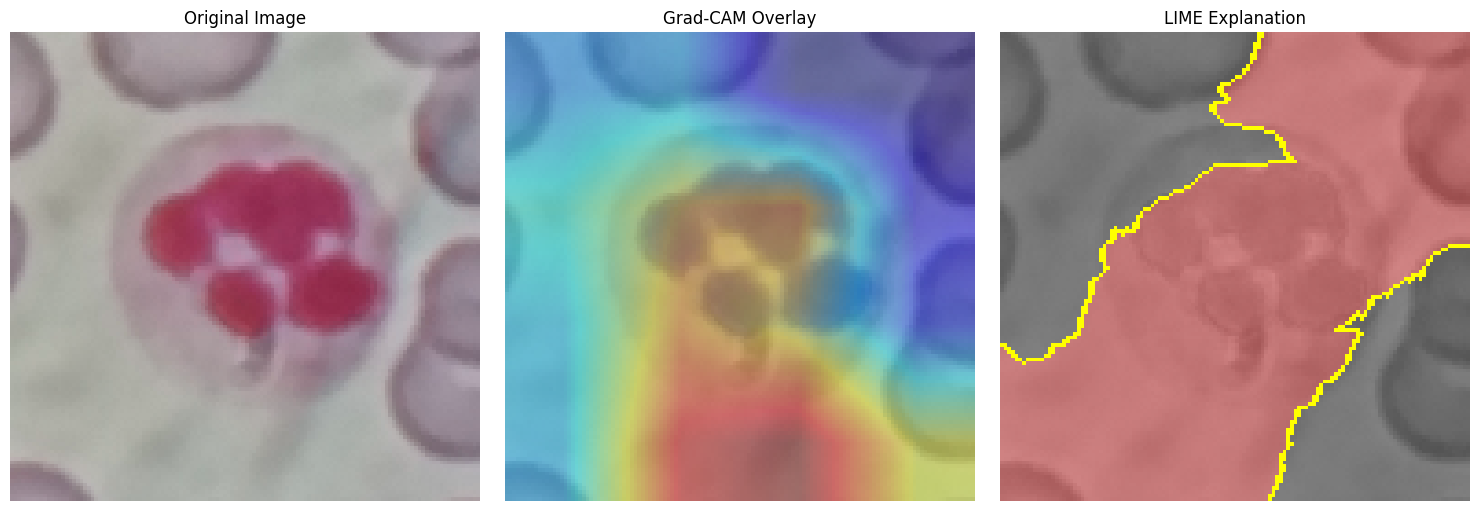

Plot saved as /mnt/c/Users/Dhruba/images for WBC/explainable AI images/Raabin_f2.tiff in the local directory.


In [251]:
## Raabin dataset ##

img_num = 2539

explainer = lime_image.LimeImageExplainer()

# Explain the prediction using LIME
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    explanation = explainer.explain_instance(x_test_raabin[img_num], best_model_c.predict, top_labels=5, hide_color=0, num_samples=500)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],  # Top predicted label
    positive_only=True,               # Show positive contributions only
    num_features=5,                   # Number of superpixels to highlight
    hide_rest=False                   # Show the rest of the image
)

# Overlay the mask on the original image
highlighted_image = label2rgb(mask, x_test_raabin[img_num], bg_label=0)


#for GradCam
image = np.expand_dims(x_test_raabin[img_num], axis=0)
heatmap = grad_cam(best_model_c, image, layer_name='conv2d_599')
# Overlay heatmap and display
overlayed_image = overlay_heatmap(heatmap, x_test_raabin[img_num]*255)

# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
# Plot each image
axes[0].imshow(x_test_raabin[img_num])
axes[0].axis('off')  # Hide axis
axes[0].set_title("Original Image")

axes[1].imshow(cv2.cvtColor(overlayed_image.astype('uint8'), cv2.COLOR_BGR2RGB))
axes[1].axis('off')
axes[1].set_title("Grad-CAM Overlay")

axes[2].imshow(mark_boundaries(highlighted_image, mask))
axes[2].axis('off')
axes[2].set_title("LIME Explanation")

# Show the plot
plt.tight_layout()
# Save the plot as a TIFF file with 300 DPI
output_filename = "/mnt/c/Users/Dhruba/images for WBC/explainable AI images/Raabin_f2.tiff"
plt.savefig(output_filename, dpi=300, format='tiff', bbox_inches='tight')
plt.show()
# Optional: Close the figure to free memory
plt.close(fig)

print(f"Plot saved as {output_filename} in the local directory.")

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/root/miniconda3/envs/tff/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['input_layer_5']]. Received: the structure of inputs=*
  warnings.warn(


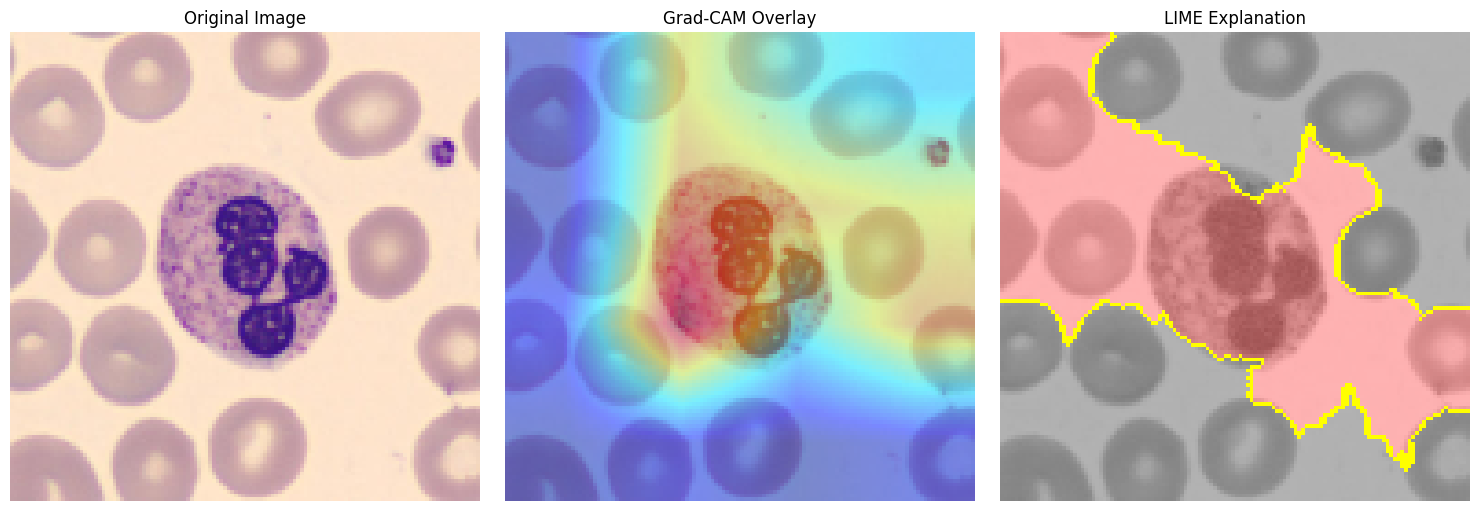

Plot saved as /mnt/c/Users/Dhruba/images for WBC/explainable AI images/pbc_f2.tiff in the local directory.


In [270]:
## PBC dataset ##

img_num = 3719

explainer = lime_image.LimeImageExplainer()

# Explain the prediction using LIME
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    explanation = explainer.explain_instance(x_test_pbc[img_num], best_model_c.predict, top_labels=5, hide_color=0, num_samples=500)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],  # Top predicted label
    positive_only=True,               # Show positive contributions only
    num_features=5,                   # Number of superpixels to highlight
    hide_rest=False                   # Show the rest of the image
)

# Overlay the mask on the original image
highlighted_image = label2rgb(mask, x_test_pbc[img_num], bg_label=0)


#for GradCam
image = np.expand_dims(x_test_pbc[img_num], axis=0)
heatmap = grad_cam(best_model_c, image, layer_name='conv2d_719')
# Overlay heatmap and display
overlayed_image = overlay_heatmap(heatmap, x_test_pbc[img_num]*255)

# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
# Plot each image
axes[0].imshow(x_test_pbc[img_num])
axes[0].axis('off')  # Hide axis
axes[0].set_title("Original Image")

axes[1].imshow(cv2.cvtColor(overlayed_image.astype('uint8'), cv2.COLOR_BGR2RGB))
axes[1].axis('off')
axes[1].set_title("Grad-CAM Overlay")

axes[2].imshow(mark_boundaries(highlighted_image, mask))
axes[2].axis('off')
axes[2].set_title("LIME Explanation")

# Show the plot
plt.tight_layout()
# Save the plot as a TIFF file with 300 DPI
output_filename = "/mnt/c/Users/Dhruba/images for WBC/explainable AI images/pbc_f2.tiff"
plt.savefig(output_filename, dpi=300, format='tiff', bbox_inches='tight')
plt.show()
# Optional: Close the figure to free memory
plt.close(fig)

print(f"Plot saved as {output_filename} in the local directory.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/root/miniconda3/envs/tff/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['input_layer']]. Received: the structure of inputs=*
  warnings.warn(


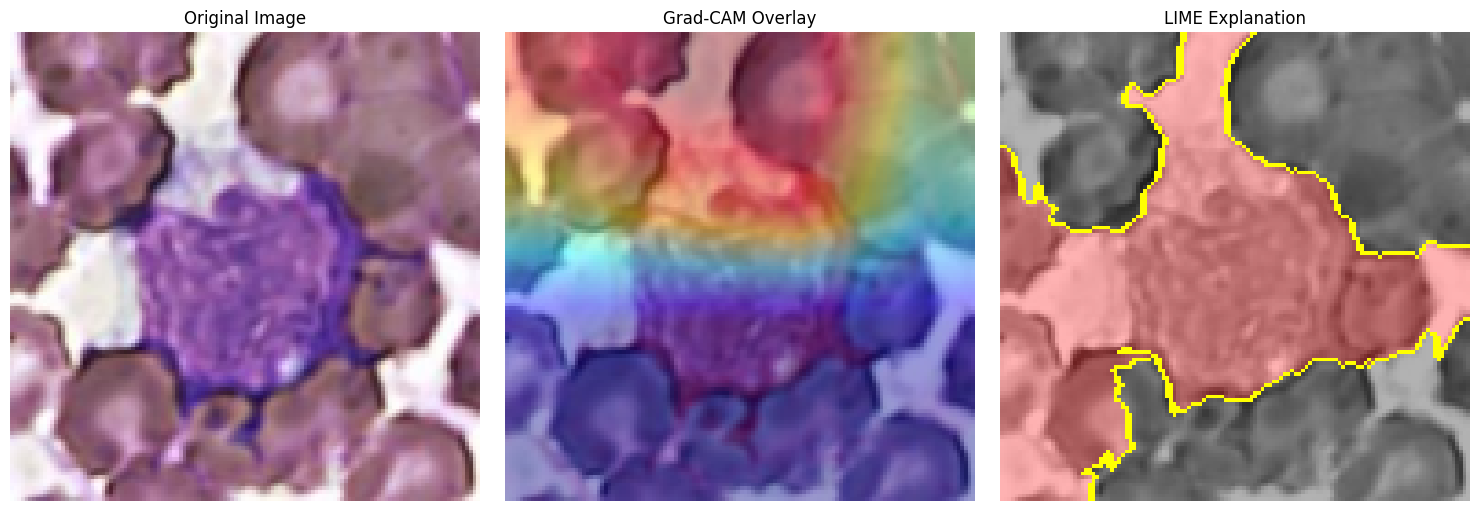

In [190]:
#img_num = 123
image = np.expand_dims(x_test_lmf[img_num], axis=0)
heatmap = grad_cam(best_model_c, image, layer_name='conv2d_119')
# Overlay heatmap and display
overlayed_image = overlay_heatmap(heatmap, x_test_lmf[img_num]*255)

# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot each image
axes[0].imshow(x_test_lmf[img_num])
axes[0].axis('off')  # Hide axis
axes[0].set_title("Original Image")

axes[1].imshow(cv2.cvtColor(overlayed_image.astype('uint8'), cv2.COLOR_BGR2RGB))
axes[1].axis('off')
axes[1].set_title("Grad-CAM Overlay")

axes[2].imshow(mark_boundaries(highlighted_image, mask))
axes[2].axis('off')
axes[2].set_title("LIME Explanation")

# Show the plot
plt.tight_layout()
plt.show()

In [171]:
#img_num = 500

explainer = lime_image.LimeImageExplainer()

# Explain the prediction using LIME
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    explanation = explainer.explain_instance(x_test_lmf[img_num], best_model_c.predict, top_labels=5, hide_color=0, num_samples=500)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],  # Top predicted label
    positive_only=True,               # Show positive contributions only
    num_features=5,                   # Number of superpixels to highlight
    hide_rest=False                   # Show the rest of the image
)

# Overlay the mask on the original image
highlighted_image = label2rgb(mask, x_test_lmf[img_num], bg_label=0)

# Plot the result
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(x_test_lmf[img_num])

plt.subplot(1, 2, 2)
plt.title("LIME Explanation")
plt.imshow(mark_boundaries(highlighted_image, mask))
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [264]:
best_model_c.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_600 (Conv2D) │ (None, 64, 64,    │      9,472 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_600[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_600 (ReLU)    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ re_lu_600[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 32, 32,    │          0 │ max_pooling2d_5[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ dropout_45[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_601 (ReLU)    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_601 (Conv2D) │ (None, 32, 32,    │      8,320 │ re_lu_601[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_601[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_602 (ReLU)    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_602 (Conv2D) │ (None, 32, 32,    │     36,896 │ re_lu_602[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_290     │ (None, 32, 32,    │          0 │ conv2d_602[0][0], │
│ (Concatenate)       │ 96)               │            │ dropout_45[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        384 │ concatenate_290[… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_603 (ReLU)    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_603 (Conv2D) │ (None, 32, 32,    │     12,416 │ re_lu_603[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_603[0][0]

 Total params: 20,992,346 (80.08 MB)

 Trainable params: 6,970,248 (26.59 MB)

 Non-trainable params: 81,600 (318.75 KB)

 Optimizer params: 13,940,498 (53.18 MB)

In [168]:
# Grad-CAM function
def grad_cam(model, image, layer_name, class_index=None):
    """
    Generate Grad-CAM heatmap for a given image and model.
    
    Args:
        model: The trained Keras model.
        image: Input image of shape (1, 128, 128, 3).
        layer_name: The name of the convolutional layer for Grad-CAM.
        class_index: The target class index (defaults to the predicted class).
    
    Returns:
        heatmap: Grad-CAM heatmap of shape (feature map height, feature map width).
    """
    # Get the model's prediction
    preds = model.predict(image)
    if class_index is None:
        class_index = np.argmax(preds[0])  # Predicted class

    # Get the target layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    # Compute gradients of the target class with respect to the feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)

    # Compute guided gradients (ReLU-ed gradients)
    guided_grads = tf.maximum(grads, 0)

    # Average the gradients spatially
    weights = tf.reduce_mean(guided_grads, axis=(0, 1, 2))

    # Compute Grad-CAM as a weighted sum of the feature maps
    conv_outputs = conv_outputs[0]
    cam = tf.reduce_sum(weights * conv_outputs, axis=-1)

    # Apply ReLU to the heatmap
    cam = tf.maximum(cam, 0).numpy()

    # Normalize the heatmap to [0, 1]
    heatmap = cam / np.max(cam)

    return heatmap

# Overlay heatmap on the input image
def overlay_heatmap(heatmap, image, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlay the heatmap on the original image.
    
    Args:
        heatmap: Grad-CAM heatmap.
        image: Original input image.
        alpha: Heatmap intensity factor.
        colormap: OpenCV colormap to apply.
    
    Returns:
        Overlayed image.
    """
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize to image size
    heatmap = np.uint8(255 * heatmap)  # Scale to [0, 255]
    heatmap = cv2.applyColorMap(heatmap, colormap)

    # Combine heatmap with the original image
    overlayed = cv2.addWeighted(image.astype('float32'), 1 - alpha, heatmap.astype('float32'), alpha, 0)
    return overlayed